In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../../")

from experiment import Exp

from dataloaders import data_set, data_dict
import torch
import yaml
import os
import pandas as pd
import matplotlib.pyplot as plt
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [3]:
args = dotdict()   

args.freq_save_path   = r"/mnt/c/Users/Murat/Desktop/Bachelor/Freq_data"
args.window_save_path = r"/mnt/c/Users/Murat/Desktop/Bachelor/Sliding_window"
args.root_path        = r"/mnt/c/Users/Murat/Desktop/Bachelor/datasets"

args.drop_transition  = False

args.batch_size       = 128
args.shuffle          = True
args.drop_last        = False
args.train_vali_quote = 0.85

In [4]:
# 哪个数据集
args.data_name           =  "hapt"  # rw hapt

# 是否作augmentation difference
args.difference          =  False 

# 是否作augmentation  filtering
args.filtering           =  False

# 是否作augmentation  magnitude
args.magnitude           = False
args.weighted_sampler    = False


# 是在load数据的时候  wavelet_filtering
args.wavelet_filtering   = True
args.number_wavelet_filtering = 10

args.datanorm_type       =  "standardization" # None ,"standardization", "minmax"

args.pos_select          = None
args.sensor_select       = None



args.representation_type = "time"
args.exp_mode            = "LOCV"

config_file = open('../../configs/data.yaml', mode='r')
data_config = yaml.load(config_file, Loader=yaml.FullLoader)
config = data_config[args.data_name]
args.root_path       = os.path.join(args.root_path,config["filename"])
args.sampling_freq   = config["sampling_freq"]
window_seconds       = config["window_seconds"]
args.windowsize      =   int(window_seconds * args.sampling_freq) 
args.c_in            =  config["num_channels"]

args.input_length    =  args.windowsize
# input information
if args.wavelet_filtering :
    
    if args.windowsize%2==1:
        N_ds = int(torch.log2(torch.tensor(args.windowsize-1)).floor()) - 2
    else:
        N_ds = int(torch.log2(torch.tensor(args.windowsize)).floor()) - 2

    args.f_in            =  args.number_wavelet_filtering*N_ds+1
else:
    args.f_in            =  1

In [5]:
dataset = data_dict[args.data_name](args)

 ----------------------- load all the data -------------------
-----------------------Sliding file are generated -----------------------
-----------------------Sliding file are generated -----------------------


In [6]:
color_map = {"acc_x":'#1f77b4',"acc_y":'#ff7f0e', "acc_z":'#2ca02c',
              "gyro_x":'#d62728',"gyro_y":'#9467bd',"gyro_z":'#8c564b'}
acc_cols = ["acc_x","acc_y","acc_z"]
gyro_cols = ["gyro_x","gyro_y","gyro_z"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Data Augmentation Channel

## ref
1. A public domain dataset for human activity recognition using smartphones
2. Separating movement and gravity components in an acceleration signal and implications for the assessment of human daily physical activity
3. InnoHAR: A deep neural network for complex human activity recognition

In [7]:
# get a random sample

In [8]:
index = 1000
window_start , windwow_end = dataset.train_slidingwindows[index][1:]
window_value = dataset.data_x.iloc[window_start:windwow_end,1:-1]

label_map = {}
for item in dataset.label_map:
    label_map[item[0]] = item[1]
window_label = dataset.data_y.iloc[window_start:windwow_end].mode().loc[0]
label = label_map[window_label]

window_value.columns = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]
window_value.reset_index(drop=True, inplace=True)
print(label)

WALKING_UPSTAIRS


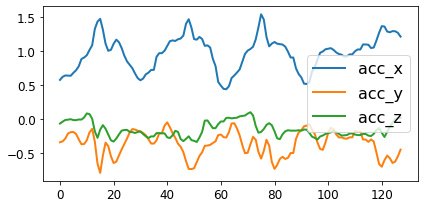

In [9]:
plt.figure(figsize=(6,3))
for col in acc_cols:
    plt.plot(window_value[col],c = color_map[col], linewidth=2,label = col)
plt.legend(fontsize=16)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\original_acc.png",dpi=300,transparent=True)
plt.show()

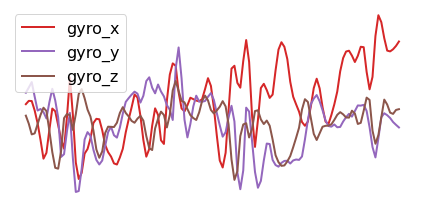

In [10]:
plt.figure(figsize=(6,3))
for col in gyro_cols:
    plt.plot(window_value[col],c = color_map[col], linewidth=2,label = col)
plt.legend(fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\original_gyro.png",dpi=300,transparent=True)
plt.show()

## Grav and Acceleration Separation/ Difference

In [11]:
from scipy import signal
fc1 = 0.3  # Cut-off frequency of the filter
w1 = fc1 / (50 / 2) # Normalize the frequency

fc2 = 20  # Cut-off frequency of the filter
w2 = fc2 / (50 / 2) # Normalize the frequency

b1, a1 = signal.butter(2, w1, 'low')
b2, a2 = signal.butter(2, [w1,w2], 'band')

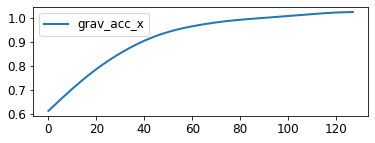

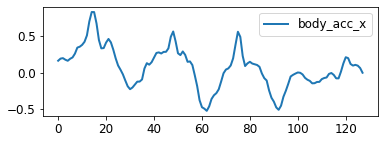

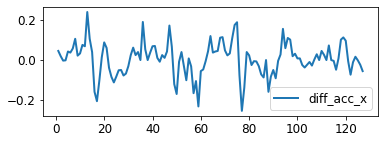

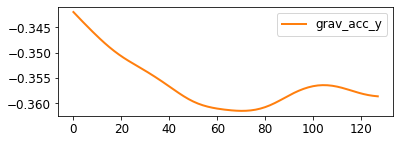

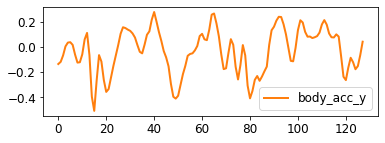

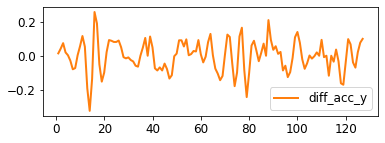

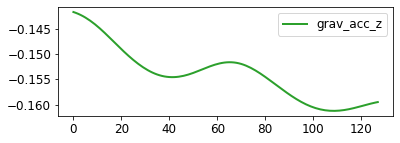

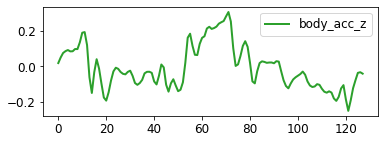

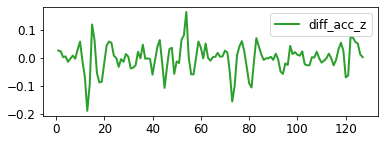

In [12]:
grav_acc_xyz = {}
body_acc_xyz = {}
for col in acc_cols:
    acc = window_value[col]
    b1, a1 = signal.butter(2, w1, 'low')
    grav = signal.filtfilt(b1, a1, acc)
    b2, a2 = signal.butter(2, [w1,w2], 'band')
    body = signal.filtfilt(b2, a2, acc)

    diff = acc.diff()
    plt.figure(figsize=(6,2))
    plt.plot(grav, label='grav_'+col,c = color_map[col], linewidth=2)
    plt.legend(fontsize=12)
    #plt.axis('off')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('grav_'+col),dpi=300,transparent=True)
    plt.show()    

    plt.figure(figsize=(6,2))
    plt.plot(body, label='body_'+col,c = color_map[col], linewidth=2)
    plt.legend(fontsize=12)
    #plt.axis('off')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('body_'+col),dpi=300,transparent=True)
    plt.show()

    plt.figure(figsize=(6,2))
    plt.plot(diff, label='diff_'+col,c = color_map[col], linewidth=2)
    plt.legend(fontsize=12)
    #plt.axis('off')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('diff_'+col),dpi=300,transparent=True)
    plt.show()

    grav_acc_xyz[col] = grav
    body_acc_xyz[col] = body

## Magnitude

In [13]:
import numpy as np
import math
def mag_3_signals(x,y,z):# magnitude function redefintion
    return np.array([math.sqrt((x[i]**2+y[i]**2+z[i]**2)) for i in range(len(x))])

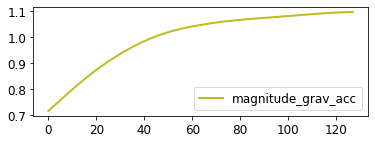

In [14]:


cols = list(grav_acc_xyz.keys())
grav_acc = mag_3_signals(grav_acc_xyz[cols[0]],grav_acc_xyz[cols[1]], grav_acc_xyz[cols[2]])

plt.figure(figsize=(6,2))
plt.plot(grav_acc, label='magnitude_grav_acc',c = '#bcbd22', linewidth=2)
plt.legend(fontsize=12)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('magnitude_grav_acc'),dpi=300,transparent=True)
plt.show()

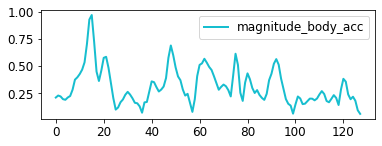

In [15]:
cols = list(body_acc_xyz.keys())
grav_acc = mag_3_signals(body_acc_xyz[cols[0]],body_acc_xyz[cols[1]], body_acc_xyz[cols[2]])

plt.figure(figsize=(6,2))
plt.plot(grav_acc, label='magnitude_body_acc',c = '#17becf', linewidth=2)
plt.legend(fontsize=12)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('magnitude_body_acc'),dpi=300,transparent=True)
plt.show()

# Data Augmentation Mixup

In [16]:
# we have to get a another sample

In [17]:
index = 106
window_start , windwow_end = dataset.train_slidingwindows[index][1:]
window_value_2 = dataset.data_x.iloc[window_start:windwow_end,1:-1]
window_label_2 = dataset.data_y.iloc[window_start:windwow_end].mode().loc[0]
label_2 = label_map[window_label_2]
    
window_value_2.columns = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]
window_value_2.reset_index(drop=True, inplace=True)
print(label_2)

WALKING


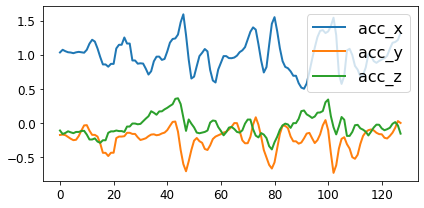

In [18]:
plt.figure(figsize=(6,3))
for col in acc_cols:
    plt.plot(window_value_2[col],c = color_map[col], linewidth=2,label = col)
plt.legend(fontsize=16)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
#plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\original_acc.png",dpi=300,transparent=True)
plt.show()

In [19]:
grav_acc_xyz_2 = {}
body_acc_xyz_2 = {}
for col in acc_cols:
    acc = window_value_2[col]
    b1, a1 = signal.butter(2, w1, 'low')
    grav = signal.filtfilt(b1, a1, acc)
    b2, a2 = signal.butter(2, [w1,w2], 'band')
    body = signal.filtfilt(b2, a2, acc)

    grav_acc_xyz_2[col] = grav
    body_acc_xyz_2[col] = body

In [20]:
body_acc_xyz_2 = pd.DataFrame(body_acc_xyz_2)
# print(body_acc_xyz)
body_acc_xyz = pd.DataFrame(body_acc_xyz)
# print('after')
# print(body_acc_xyz)
# Q3
# x1 = np.expand_dims(body_acc_xyz.values,0)
# x2 = np.expand_dims(body_acc_xyz_2.values,0)
x1 = body_acc_xyz.values
x2 = body_acc_xyz_2.values
x = 0.7*x1 + 0.3*x2
body = x[:,1]
print(body)
x = pd.DataFrame(x)
x.columns = ['acc_x', 'acc_y', 'acc_z']
print(x.to_markdown())

[-0.0957651  -0.08101412 -0.04705619 -0.00337204  0.01070699  0.00716399
 -0.00504392 -0.04225379 -0.06162185 -0.03637682  0.00862934  0.06966908
  0.08796876 -0.03624105 -0.27298301 -0.38637562 -0.25054243 -0.11788485
 -0.1539242  -0.25769193 -0.3062903  -0.24120903 -0.15473167 -0.09928372
 -0.03435238  0.0377601   0.10205506  0.13550545  0.1299533   0.10837968
  0.08998521  0.07880271  0.06184457  0.02903398 -0.00056077 -0.00836677
  0.03718104  0.09526174  0.12084443  0.19024248  0.24498315  0.20925073
  0.16996909  0.12301669  0.0204548  -0.09122488 -0.2085985  -0.33140069
 -0.36523706 -0.3202984  -0.26516362 -0.19325544 -0.14358731 -0.1087417
 -0.07395595 -0.07171807 -0.04473833 -0.00181425  0.03536188  0.09539793
  0.11446869  0.08978382  0.09054231  0.15839117  0.25502447  0.27778447
  0.22198921  0.11497888 -0.02583113 -0.12286036 -0.11636875 -0.00375411
  0.12942124  0.12667565 -0.02488958 -0.15224724 -0.12668324 -0.05190022
 -0.14055342 -0.32688418 -0.3706615  -0.26914083 -0.

In [21]:
# take body as example
col_ = "acc_x"
col = "body_"+col_

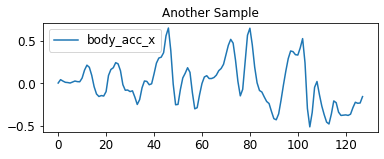

In [22]:
plt.figure(figsize=(6,2))
plt.plot(x2[:,0], label=col,c=color_map[col_], linewidth=1.5)
plt.legend(fontsize=12)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Another Sample", fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format("another_"+col),dpi=300,transparent=True)
plt.show()

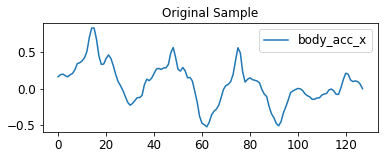

In [23]:
plt.figure(figsize=(6,2))
plt.plot(x1[:,0], label=col,c=color_map[col_], linewidth=1.5)
plt.legend(fontsize=12)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Original Sample", fontsize=12)
plt.show()

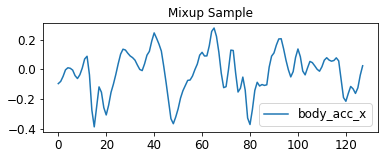

In [24]:
plt.figure(figsize=(6,2))
plt.plot(body, label=col,c=color_map[col_], linewidth=1.5)
plt.legend(fontsize=12)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Mixup Sample", fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format("mixup_"+col),dpi=300,transparent=True)
plt.show()

# Data Augmentation Random

In [25]:
# grav_acc_xyz = {}
# body_acc_xyz = {}
# for col in ["acc_x"]:
#     acc = window_value[col]
#     b1, a1 = signal.butter(2, w1, 'low')
#     grav = signal.filtfilt(b1, a1, acc)
#     b2, a2 = signal.butter(2, [w1,w2], 'band')
#     body = signal.filtfilt(b2, a2, acc)

#     diff = acc.diff()
#     plt.figure(figsize=(6,2))
#     plt.plot(grav, label='grav_'+col,c = color_map[col], linewidth=2)
#     plt.legend(fontsize=14)
#     plt.axis('off')
#     #plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('grav_'+col),dpi=300,tranparent=True)
#     plt.show()    
#     plt.figure(figsize=(6,2))
#     plt.plot(body, label='body_'+col,c = color_map[col], linewidth=2)
#     plt.legend(fontsize=14)
#     plt.axis('off')
#     #plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('body_'+col),dpi=300,tranparent=True)
#     plt.show()
#     plt.figure(figsize=(6,2))
#     plt.plot(diff, label='diff_'+col,c = color_map[col], linewidth=2)
#     plt.legend(fontsize=14)
#     plt.axis('off')
#     #plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('diff_'+col),dpi=300,tranparent=True)
#     plt.show()
#     grav_acc_xyz[col] = grav
#     body_acc_xyz[col] = body

## Jitter Noise

<class 'numpy.ndarray'>


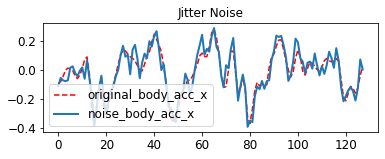

In [26]:
import numpy as np
from tqdm import tqdm
import pandas as pd
def jitter(x, sigma=0.05):
    # https://arxiv.org/pdf/1706.00527.pdf
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

# TODO sigma vary
print(type(body))

plt.figure(figsize=(6,2))
plt.plot(body, label="original_"+col,c = "red", linewidth=1.5,linestyle='dashed')
plt.plot(jitter(body), label="noise_"+col,c = color_map[col_], linewidth=2)

plt.legend(fontsize=12)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Jitter Noise", fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format("noise_"+col),dpi=300,transparent=True)
plt.show()

## Expotional Smoothing

In [27]:
def expotional_smoothing(x):
    length = x.shape[1]
    alpha = 0.2
    ret = np.zeros_like(x)
    for dim in range(x.shape[0]):
        ret[dim,0] =   x[dim,0] 
        for index in range(1,length):
            ret[dim,index] =   alpha * x[dim,index-1] + (1-alpha)* ret[dim,index-1]

    return ret

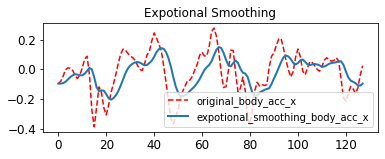

In [28]:
plt.figure(figsize=(6,2))
plt.plot(body, label="original_"+col,c = "red", linewidth=1.5,linestyle='dashed')
plt.plot(expotional_smoothing(body.reshape(1,-1)).reshape(-1), label="expotional_smoothing_"+col,c = color_map[col_], linewidth=2)
plt.legend(fontsize=10)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Expotional Smoothing", fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format("expotional_smoothing_"+col),dpi=300,tranparent=True)
plt.show()

## Moving Average

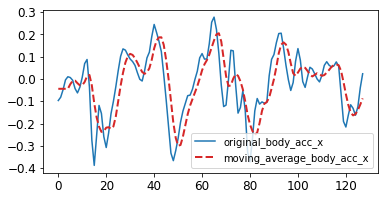

In [57]:
def moving_average(x):
    df = pd.DataFrame(x.T)
    ret = df.rolling(window =5).mean()
    ret = ret.interpolate(method='linear', limit_direction='both')
    return ret.values
plt.figure(figsize=(6,3))
plt.plot(body, label="original_"+col, linewidth=1.5, c = color_map['acc_x'])
plt.plot(moving_average(body.reshape(1,-1)).reshape(-1), label="moving_average_"+col,c = color_map['gyro_x'], linewidth=2, linestyle='dashed')
plt.legend(fontsize=10)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title("Moving Average", fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format("moving_average_"+col),dpi=300,tranparent=True)
plt.show()

## Magnitude scaling

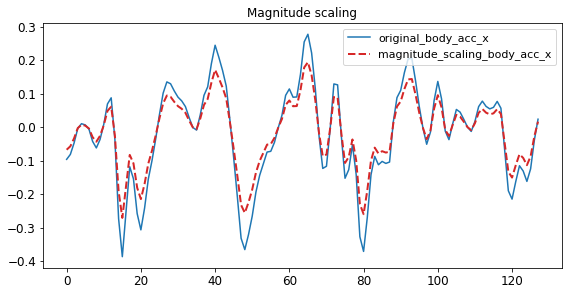

In [66]:
def scaling(x, sigma=0.5):
    # https://arxiv.org/pdf/1706.00527.pdf
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[1]))
    factor = np.ones_like(factor)*0.7
    return np.multiply(x, factor[np.newaxis,:])

plt.figure(figsize=(8,4))
plt.plot(body, label="original_"+col,c = color_map['acc_x'], linewidth=1.5)
plt.plot(scaling(body.reshape(1,-1)).reshape(-1), label="magnitude_scaling_"+col,c = color_map['gyro_x'], linewidth=2, linestyle='dashed')
plt.legend(fontsize=11)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.title("Magnitude scaling", fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format("Magnitude_scaling_"+col),dpi=300,tranparent=True)
plt.show()

## magnitude_warp

(128, 1)
[[2.14995528]
 [1.9405212 ]
 [0.92656285]
 [0.89599165]
 [0.84503557]
 [1.28813024]]


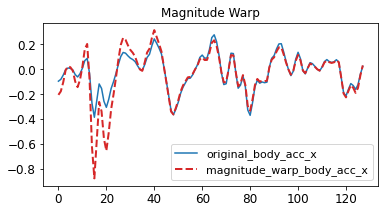

In [96]:
def magnitude_warp(x, sigma=0.4, knot=6):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[0])
    print(x.shape)
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=( knot, x.shape[1]))
    print(random_warps)
    warp_steps = (np.ones((x.shape[1],1))*(np.linspace(0, x.shape[0]-1., num=knot))).T


    warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[:,dim])(orig_steps) for dim in range(x.shape[1])]).T

    ret = x * warper
    #plt.plot(warper)

    return ret

from tabulate import tabulate
plt.figure(figsize=(6,3))
plt.plot(body, label="original_"+col,c = color_map['acc_x'], linewidth=1.5)
res = magnitude_warp(body.reshape(-1,1))
plt.plot(res.reshape(-1), label="magnitude_warp_"+col,c = color_map['gyro_x'], linewidth=2,linestyle='dashed')
# print(body)
# print(tabulate(res))
plt.legend(fontsize=11)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Magnitude Warp", fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format("Magnitude_warp_"+col),dpi=300,tranparent=True)
plt.show()

## Magnitude Shift

(1, 128)
(1, 128)
-----------
-0.0673259
-0.0525749
-0.018617
 0.0250672
 0.0391462
 0.0356032
 0.0233953
-0.0138146
-0.0331826
-0.00793761
 0.0370686
 0.0981083
 0.116408
-0.00780184
-0.244544
-0.357936
-0.222103
-0.0894456
-0.125485
-0.229253
-0.277851
-0.21277
-0.126292
-0.0708445
-0.00591317
 0.0661993
 0.130494
 0.163945
 0.158393
 0.136819
 0.118424
 0.107242
 0.0902838
 0.0574732
 0.0278784
 0.0200724
 0.0656203
 0.123701
 0.149284
 0.218682
 0.273422
 0.23769
 0.198408
 0.151456
 0.048894
-0.0627857
-0.180159
-0.302961
-0.336798
-0.291859
-0.236724
-0.164816
-0.115148
-0.0803025
-0.0455167
-0.0432789
-0.0162991
 0.026625
 0.0638011
 0.123837
 0.142908
 0.118223
 0.118982
 0.18683
 0.283464
 0.306224
 0.250428
 0.143418
 0.00260808
-0.0944211
-0.0879295
 0.0246851
 0.15786
 0.155115
 0.00354963
-0.123808
-0.098244
-0.023461
-0.112114
-0.298445
-0.342222
-0.240702
-0.113433
-0.0583811
-0.0834077
-0.0734784
-0.0794713
-0.0752948
 0.0440118
 0.117132
 0.138819
 0.191921
 0.232678
 

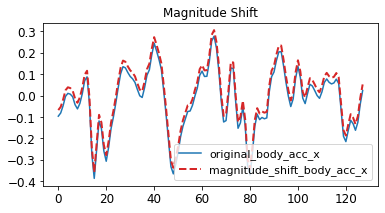

In [117]:
def magnitude_shift(x):
    ratio = 0.2
    ret = np.zeros_like(x)
    print(x.shape)
    for dim in range(x.shape[0]):
        #print(x[dim,:].mean())
        ret[dim,:] =x[dim,:]+max(np.mean(x[dim,:])*ratio,np.std(x[dim,:])*ratio)
    return ret
plt.figure(figsize=(6,3))
plt.plot(body, label="original_"+col, c = color_map['acc_x'], linewidth=1.5,)
plt.plot(magnitude_shift(body.reshape(1,-1)).reshape(-1), label="magnitude_shift_"+col,c = color_map['gyro_x'], linewidth=2, linestyle='dashed')
plt.legend(fontsize=11)
#plt.axis('off')
print(tabulate(magnitude_shift(body.reshape(1,-1)).transpose()))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Magnitude Shift", fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format("magnitude_shift_"+col),dpi=300,tranparent=True)
plt.show()

## Time Warping

[1.03423989 1.00485069 0.94307746 0.99251264 1.01287958 1.02771023
 1.04488297]


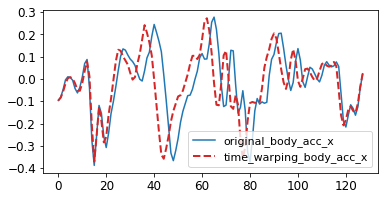

[1.03423989 1.00485069 0.94307746 0.99251264 1.01287958 1.02771023
 1.04488297]
[-0.0957651  -0.083126   -0.05620076 -0.01987225  0.00412035  0.00907396
  0.00217064 -0.01906885 -0.04932137 -0.05219954 -0.0182845   0.03616875
  0.07919575  0.01220886 -0.20638984 -0.36894189 -0.25166706 -0.12350357
 -0.18875619 -0.28342158 -0.25842047 -0.15886705 -0.08771301 -0.00475389
  0.07932406  0.13162444  0.12735416  0.10188188  0.08349723  0.06524986
  0.0287917  -0.00214934  0.00916805  0.06919044  0.11318603  0.17861343
  0.24200304  0.20773343  0.16475425  0.10622063 -0.00168012 -0.11662617
 -0.23564394 -0.33855046 -0.35664944 -0.31142422 -0.25638342 -0.18949699
 -0.14279608 -0.10999606 -0.07741266 -0.07209041 -0.05111009 -0.01503114
  0.02120486  0.06813768  0.10442049  0.10455757  0.09003558  0.10853601
  0.17792818  0.25829337  0.27277166  0.21764118  0.115431   -0.019516
 -0.11493401 -0.11711542 -0.02009683  0.10647716  0.12721603  0.0083071
 -0.12177871 -0.13327298 -0.07246366 -0.1147397

In [131]:
def time_warp(x, sigma=0.05, knot=5):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[0])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(knot+2))
    random_warps = np.asarray([1.03423989,1.00485069,0.94307746,0.99251264,1.01287958,1.02771023, 1.04488297])
    print(random_warps)
    #plt.plot(random_warps)
    warp_steps = (np.ones((x.shape[1],1))*(np.linspace(0, x.shape[0]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)

    for dim in range(x.shape[1]):
        time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps)(orig_steps)
        #plt.figure()
        #plt.plot(time_warp)
        scale = (x.shape[0]-1)/time_warp[-1]
        ret[:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[0]-1), x[:,dim]).T
    return ret



plt.figure(figsize=(6,3))
plt.plot(body, label="original_"+col,c = color_map['acc_x'], linewidth=1.5,)
plt.plot(time_warp(body.reshape(-1,1)).reshape(-1), label="time_warping_"+col,c = color_map['gyro_x'], linewidth=2, linestyle='dashed')
plt.legend(fontsize=11)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title("Time Warp", fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format("Time_warp_"+col),dpi=300,tranparent=True)
plt.show()
print(time_warp(body.reshape(-1,1)).reshape(-1))

## Window Warping

In [ ]:
def window_warp(x, window_ratio=0.15, scales=[0.5, 2.]):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    warp_scales = np.random.choice(scales, 1)
    print(x.shape)
    print(warp_scales)
    warp_size = np.ceil(window_ratio*x.shape[1]).astype(int)

    window_steps = np.arange(warp_size)
    print(warp_size)
    window_starts = np.random.randint(low=1, high=x.shape[1]-warp_size-1, size=1).astype(int)
    print(window_starts)
    window_ends = (window_starts + warp_size).astype(int)
    print(window_ends)            
    ret = np.zeros_like(x)

    for dim in range(x.shape[0]):
        start_seg = x[dim,:window_starts[0]]
        window_seg = np.interp(np.linspace(0, warp_size-1, num=int(warp_size*warp_scales[0])), window_steps, x[dim,window_starts[0]:window_ends[0]])
        end_seg = x[dim,window_ends[0]:]

        warped = np.concatenate((start_seg, window_seg, end_seg))                
        ret[dim,:] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1]-1., num=warped.size), warped).T
    return ret
plt.figure(figsize=(6,2))
plt.plot(body, label="original_"+col,c = color_map['acc_x'], linewidth=1.5,)
res = window_warp(body.reshape(1,-1))
plt.plot(res.reshape(-1), label="window_warping_"+col,c = color_map['gyro_x'], linewidth=2, linestyle='dashed')
plt.legend(fontsize=10)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Window Warping", fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format("window_warping_"+col),dpi=300,tranparent=True)
plt.show()

## Window Slicing

[10]
[126]


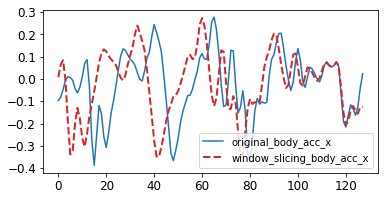

In [195]:
def window_slice(x, reduce_ratio=0.9):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(1)).astype(int)
    ends = (target_len + starts).astype(int)
    print(starts)
    print(ends)
    ret = np.zeros_like(x)

    for dim in range(x.shape[0]):
        ret[dim,:] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), x[dim,starts[0]:ends[0]]).T
    return ret
plt.figure(figsize=(6,3))
plt.plot(body, label="original_"+col,c = color_map['acc_x'], linewidth=1.5)
res = window_slice(body.reshape(1,-1))
plt.plot(res.reshape(-1), label="window_slicing_"+col,c = color_map['gyro_x'], linewidth=2, linestyle='dashed')
plt.legend(fontsize=10)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title("Window Warping", fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format("window_slicing_"+col),dpi=300,tranparent=True)
plt.show()

## Random Sampling

[0, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 22, 23, 24, 26, 28, 29, 30, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 71, 72, 73, 74, 75, 76, 77, 78, 81, 83, 84, 85, 87, 88, 89, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 118, 119, 121, 123, 124, 125, 126, 127]


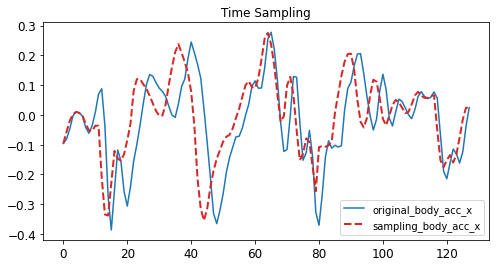

In [204]:
def random_sampling(x, reduce_ratio=0.8):
    import random
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x

    index_list = list(np.arange(x.shape[1]))
    sampled_index = random.sample(index_list, target_len)
    sampled_index = sorted(sampled_index)
    print(sampled_index)

    ret = np.zeros_like(x)

    for dim in range(x.shape[0]):
        ret[dim,:] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), x[dim,sampled_index]).T
    return ret
plt.figure(figsize=(8,4))
plt.plot(body, label="original_"+col,c = color_map['acc_x'], linewidth=1.5,)
res = random_sampling(body.reshape(1,-1))
plt.plot(res.reshape(-1), label="sampling_"+col,c = color_map['gyro_x'], linewidth=2,linestyle='dashed')
plt.legend(fontsize=10)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Time Sampling", fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format("sampling_"+col),dpi=300,tranparent=True)
plt.show()

## Slope Adding

65


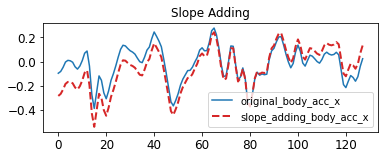

In [209]:
def slope_adding(x):
    import random
    anchor = random.randint(0, x.shape[1])
    print(anchor)
    anchor = 80
    ret = np.zeros_like(x)
    for dim in range(x.shape[0]):
        slope = random.uniform(-0.2,0.2)
        slope = 0.3
        slope = slope/x.shape[1]
        slope = np.linspace(0, x.shape[1]-1,x.shape[1])*slope
        shift = slope[anchor]
        slope = slope -shift
        
        ret[dim,:] =   x[dim,:] + slope
    return ret
plt.figure(figsize=(6,2))
plt.plot(body, label="original_"+col,c = color_map['acc_x'], linewidth=1.5)
res = slope_adding(body.reshape(1,-1))
plt.plot(res.reshape(-1), label="slope_adding_"+col,c = color_map['gyro_x'], linewidth=2, linestyle='dashed')
plt.legend(fontsize=10)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Slope Adding", fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format("slope_adding_"+col),dpi=300,tranparent=True)
plt.show()

In [210]:
print(tabulate(res.T))

-----------
-0.283265
-0.26617
-0.229869
-0.183841
-0.167418
-0.168617
-0.178481
-0.213348
-0.230372
-0.202783
-0.155433
-0.0920497
-0.0714062
-0.193272
-0.427671
-0.538719
-0.400542
-0.265541
-0.299237
-0.400661
-0.446915
-0.37949
-0.290669
-0.232877
-0.165602
-0.0911461
-0.0245074
 0.0112867
 0.0080783
-0.0111516
-0.0272023
-0.036041
-0.0506554
-0.0811223
-0.108373
-0.113836
-0.065944
-0.00551951
 0.0224069
 0.0941487
 0.151233
 0.117844
 0.0809066
 0.0362979
-0.0639202
-0.173256
-0.288286
-0.408744
-0.440237
-0.392955
-0.335476
-0.261224
-0.209212
-0.172023
-0.134893
-0.130312
-0.100988
-0.0557205
-0.0162006
 0.0461792
 0.0675937
 0.0452526
 0.0483548
 0.118547
 0.217524
 0.242628
 0.189177
 0.0845101
-0.0539561
-0.148642
-0.139806
-0.0248479
 0.110671
 0.110269
-0.0389521
-0.163966
-0.136058
-0.0589315
-0.145241
-0.329228
-0.370662
-0.266797
-0.137184
-0.0797891
-0.102472
-0.0901989
-0.093848
-0.0873278
 0.0343226
 0.109786
 0.133817
 0.189263
 0.232364
 0.236336
 0.171993
 0.09728

# Reference


1. https://arxiv.org/pdf/2002.12478.pdf
2. https://arxiv.org/pdf/2109.01081.pdf
3. https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0254841
4. https://link.springer.com/content/pdf/10.1007/s11042-021-10600-0.pdf
5. https://openaccess.thecvf.com/content_CVPRW_2020/papers/w40/Cubuk_Randaugment_Practical_Automated_Data_Augmentation_With_a_Reduced_Search_Space_CVPRW_2020_paper.pdf
6. https://link.springer.com/content/pdf/10.1007/s12652-020-02865-4.pdf


85


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

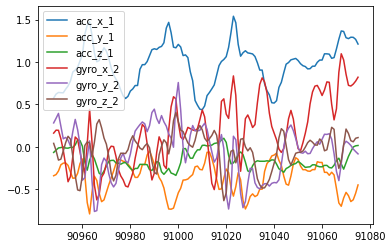

<Figure size 432x288 with 0 Axes>

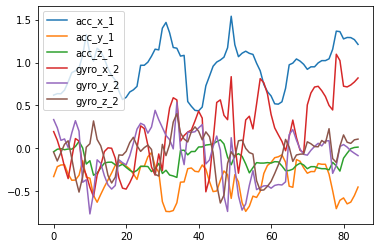

<Figure size 432x288 with 0 Axes>

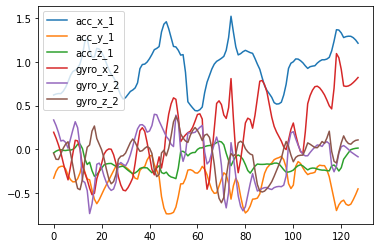

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tslearn.preprocessing import TimeSeriesResampler
import pandas as pd
window = args.windowsize  



index = 1000
start_index  =  dataset.train_slidingwindows[index][1]
end_index    =  dataset.train_slidingwindows[index][2]
original_data = dataset.data_x.iloc[start_index:end_index, 1:-1]
plt.figure()
original_data.plot()

length_sample  = np.random.randint(int(0.6*window), int(0.8*window))
print(length_sample)
index_list = list(np.arange(window))
sampled_index = random.sample(index_list, length_sample)
sampled_index = sorted(sampled_index)
original_values = original_data.values
sampled_Values = original_values[sampled_index]
sample_data = pd.DataFrame(sampled_Values)
sample_data.columns = original_data.columns
plt.figure()
sample_data.plot()


resize_data = pd.DataFrame()
for col in sample_data.columns:
    ts = sample_data[col].values
    new_ts = TimeSeriesResampler(sz=window).fit_transform(ts)
    resize_data[col] = np.squeeze(new_ts)
plt.figure()
resize_data.plot()



In [ ]:
plt.plot(all_t_DC_component[window_start:windwow_end])
plt.plot(all_t_body_component[window_start:windwow_end])
plt.plot(all_t_DC_component[window_start:windwow_end]+all_t_body_component[window_start:windwow_end])
plt.plot(np.array(dataset.data_x[dataset.data_x["sub_id"]=="1_1"]["acc_z_1"])[window_start:windwow_end])

NameError: name 'all_t_DC_component' is not defined

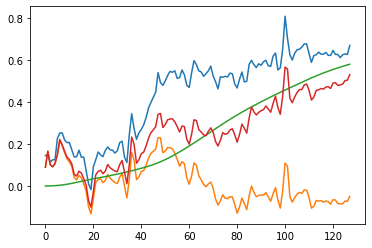

In [ ]:
window_start , windwow_end = dataset.train_slidingwindows[50][1:]
window_value = dataset.data_x.iloc[window_start:windwow_end,1:-1]
acc_z_1 = window_value["acc_z_1"].values
plt.plot(acc_z_1)
y = butter_bandpass_filter(acc_z_1, 0.3, 20, 50, order=2)
y2 = butter_bandpass_filter(acc_z_1, 0.0001, 0.3, 50, order=2)
plt.plot(y)
plt.plot(y2)
plt.plot(y+y2)

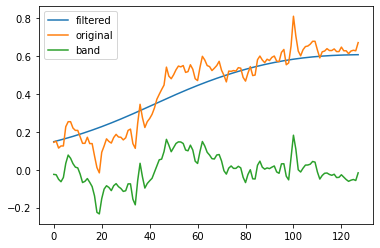

In [ ]:
from scipy import signal
fc = 0.3  # Cut-off frequency of the filter
w = fc / (50 / 2) # Normalize the frequency
b, a = signal.butter(2, w, 'low')
output = signal.filtfilt(b, a, acc_z_1)



plt.plot(output, label='filtered')
plt.plot(acc_z_1, label='original')

fc1 = 0.3  # Cut-off frequency of the filter
w1 = fc1 / (50 / 2) # Normalize the frequency

fc2 = 20  # Cut-off frequency of the filter
w2 = fc2 / (50 / 2) # Normalize the frequency
b, a = signal.butter(2, [w1,w2], 'band')
output = signal.filtfilt(b, a, acc_z_1)
plt.plot(output, label='band')
plt.legend()
plt.show()

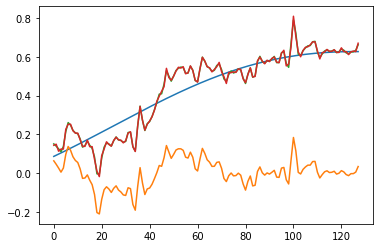

In [ ]:
plt.plot(all_t_DC_component[window_start:windwow_end])
plt.plot(all_t_body_component[window_start:windwow_end])
plt.plot(all_t_DC_component[window_start:windwow_end]+all_t_body_component[window_start:windwow_end])
plt.plot(np.array(dataset.data_x[dataset.data_x["sub_id"]=="1_1"]["acc_z_1"])[window_start:windwow_end])

In [ ]:
y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)

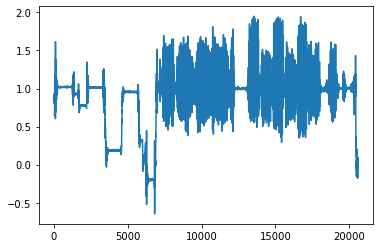

In [ ]:
import math 
import numpy as np
import matplotlib.pyplot as plt
# necessary functions
from scipy.fftpack import fft,fftfreq,ifft
# Importing Scipy 
import scipy as sp
sampling_freq = 50
temp = dataset.data_x[dataset.data_x["sub_id"]=="1_1"]
acc_x_1 = temp["acc_x_1"]
plt.plot(acc_x_1)


t_signal=np.array(acc_x_1)
t_signal_length=len(t_signal) # number of points in a t_signal

# the t_signal in frequency domain after applying fft
f_signal=fft(t_signal) # 1D numpy array contains complex values (in C)

# generate frequencies associated to f_signal complex values
freqs=np.array(sp.fftpack.fftfreq(t_signal_length, d=1/float(sampling_freq))) # frequency values between [-25hz:+25hz]

In [ ]:
temp = dataset.data_x[dataset.data_x["sub_id"]=="1_1"]
acc_z_1 = temp["acc_z_1"]

t_signal=np.array(acc_z_1)
t_signal_length=len(t_signal) # number of points in a t_signal

# the t_signal in frequency domain after applying fft
f_signal=fft(t_signal) # 1D numpy array contains complex values (in C)

# generate frequencies associated to f_signal complex values
freqs=np.array(sp.fftpack.fftfreq(t_signal_length, d=1/float(sampling_freq))) # frequency values between [-25hz:+25hz]

freq1=0.3
freq2 = 20
f_DC_signal=[] # DC_component in freq domain
f_body_signal=[] # body component in freq domain numpy.append(a, a[0])
f_noise_signal=[] # noise in freq domain


for i in range(len(freqs)):# iterate over all available frequencies

    # selecting the frequency value
    freq=freqs[i]

    # selecting the f_signal value associated to freq
    value= f_signal[i]

    # Selecting DC_component values 
    if abs(freq)>freq1:# testing if freq is outside DC_component frequency ranges
        f_DC_signal.append(float(0)) # add 0 to  the  list if it was the case (the value should not be added)                                       
    else: # if freq is inside DC_component frequency ranges 
        f_DC_signal.append(value) # add f_signal value to f_DC_signal list

    # Selecting noise component values 
    if (abs(freq)<=freq2):# testing if freq is outside noise frequency ranges 
        f_noise_signal.append(float(0)) # # add 0 to  f_noise_signal list if it was the case 
    else:# if freq is inside noise frequency ranges 
        f_noise_signal.append(value) # add f_signal value to f_noise_signal

    # Selecting body_component values 
    if (abs(freq)<=freq1 or abs(freq)>freq2):# testing if freq is outside Body_component frequency ranges
        f_body_signal.append(float(0))# add 0 to  f_body_signal list
    else:# if freq is inside Body_component frequency ranges
        f_body_signal.append(value) # add f_signal value to f_body_signal list
all_t_DC_component= ifft(np.array(f_DC_signal)).real
all_t_body_component= ifft(np.array(f_body_signal)).real

In [ ]:
window_start , windwow_end = dataset.train_slidingwindows[50][1:]
window_value = dataset.data_x.iloc[window_start:windwow_end,1:-1]
acc_z_1 = window_value["acc_z_1"]

t_signal=np.array(acc_z_1)
t_signal_length=len(t_signal) # number of points in a t_signal

# the t_signal in frequency domain after applying fft
f_signal=fft(t_signal) # 1D numpy array contains complex values (in C)

# generate frequencies associated to f_signal complex values
freqs=np.array(sp.fftpack.fftfreq(t_signal_length, d=1/float(sampling_freq))) # frequency values between [-25hz:+25hz]

freq1=0.9
freq2 = 20
f_DC_signal=[] # DC_component in freq domain
f_body_signal=[] # body component in freq domain numpy.append(a, a[0])
f_noise_signal=[] # noise in freq domain


for i in range(len(freqs)):# iterate over all available frequencies

    # selecting the frequency value
    freq=freqs[i]

    # selecting the f_signal value associated to freq
    value= f_signal[i]

    # Selecting DC_component values 
    if abs(freq)>freq1:# testing if freq is outside DC_component frequency ranges
        f_DC_signal.append(float(0)) # add 0 to  the  list if it was the case (the value should not be added)                                       
    else: # if freq is inside DC_component frequency ranges 
        f_DC_signal.append(value) # add f_signal value to f_DC_signal list

    # Selecting noise component values 
    if (abs(freq)<=freq2):# testing if freq is outside noise frequency ranges 
        f_noise_signal.append(float(0)) # # add 0 to  f_noise_signal list if it was the case 
    else:# if freq is inside noise frequency ranges 
        f_noise_signal.append(value) # add f_signal value to f_noise_signal

    # Selecting body_component values 
    if (abs(freq)<=freq1 or abs(freq)>freq2):# testing if freq is outside Body_component frequency ranges
        f_body_signal.append(float(0))# add 0 to  f_body_signal list
    else:# if freq is inside Body_component frequency ranges
        f_body_signal.append(value) # add f_signal value to f_body_signal list
window_t_DC_component= ifft(np.array(f_DC_signal)).real
window_t_body_component= ifft(np.array(f_body_signal)).real

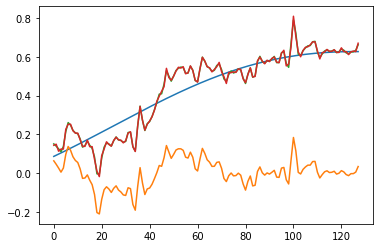

In [ ]:
plt.plot(all_t_DC_component[window_start:windwow_end])
plt.plot(all_t_body_component[window_start:windwow_end])
plt.plot(all_t_DC_component[window_start:windwow_end]+all_t_body_component[window_start:windwow_end])
plt.plot(np.array(dataset.data_x[dataset.data_x["sub_id"]=="1_1"]["acc_z_1"])[window_start:windwow_end])

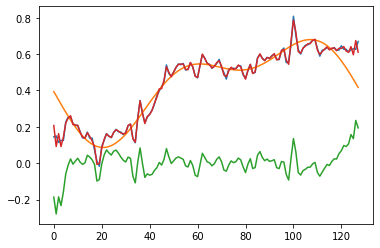

In [ ]:
plt.plot(t_signal)
plt.plot(window_t_DC_component)
plt.plot(window_t_body_component)
plt.plot(window_t_body_component+window_t_DC_component)

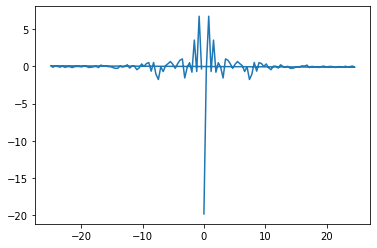

In [ ]:
plt.plot(freqs,f_signal)

# Data Augmentation Draft To Delete

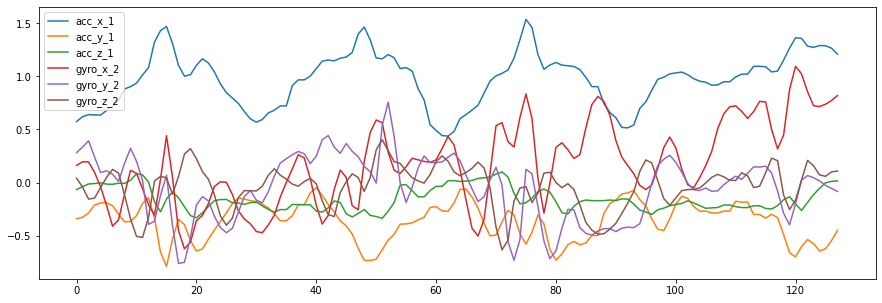

In [ ]:
index = 1000
start_index  =  dataset.train_slidingwindows[index][1]
end_index    =  dataset.train_slidingwindows[index][2]
original_data = dataset.data_x.iloc[start_index:end_index, 1:-1].reset_index(drop=True)

original_data.plot(figsize=(15,5))
plt.show()

## Magnitude scaling

In [ ]:
def scaling(x, sigma=0.2):
    # https://arxiv.org/pdf/1706.00527.pdf
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[1]))
    return np.multiply(x, factor[np.newaxis,:])

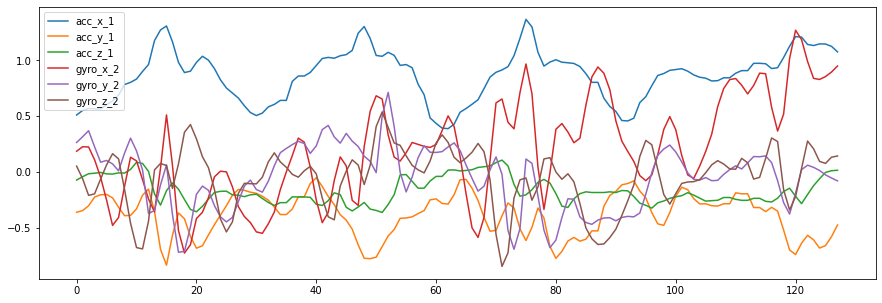

In [ ]:
scaled_data = pd.DataFrame(scaling(original_data.values), columns  = original_data.columns)
scaled_data.plot(figsize=(15,5))
plt.show()

## Mantitute Wrap

In [ ]:
def magnitude_warp(x, sigma=0.1, knot=6):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[0])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=( knot, x.shape[1]))

    warp_steps = (np.ones((x.shape[1],1))*(np.linspace(0, x.shape[0]-1., num=knot))).T


    warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[:,dim])(orig_steps) for dim in range(x.shape[1])]).T

    ret = x * warper
    plt.plot(warper)

    return ret

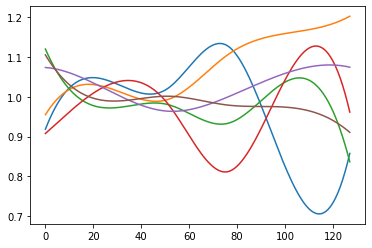

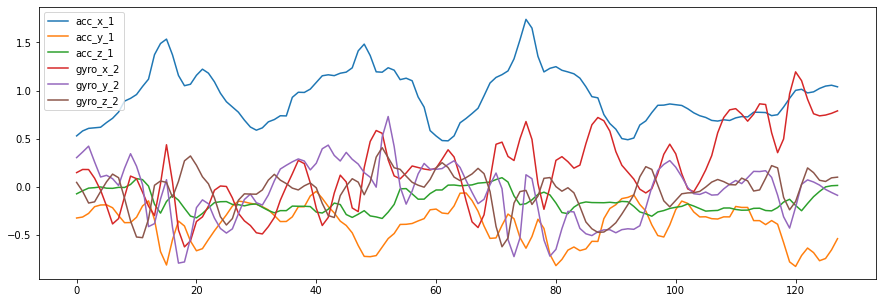

In [ ]:
magnitude_warp_data = pd.DataFrame(magnitude_warp(original_data.values), columns  = original_data.columns)
magnitude_warp_data.plot(figsize=(15,5))
plt.show()

<AxesSubplot:>

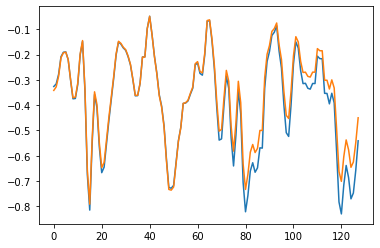

In [ ]:
magnitude_warp_data["acc_y_1"].plot()
original_data["acc_y_1"].plot()

## Window Warping (WW)

The last data augmentation technique we use is more time-series specific. It consists in warping a randomly selected slice of a time series by speeding it up or down, as shown in Fig. 2. The size of the original slice is a parameter of this method. Fig. 2 shows a time series from the “ECG200” dataset and corresponding transformed data. Note that this method generates input time series of different lengths. To deal with this issue, we perform window slicing on transformed time series for all to have equal length. In this paper, we only consider warping ratios equal to 0.5 or 2, but other ratios could be used and the optimal ratio could even be fine tuned through cross-validation on the training set. In the following, this method will be referred to as window warping (WW).

19       0.5


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

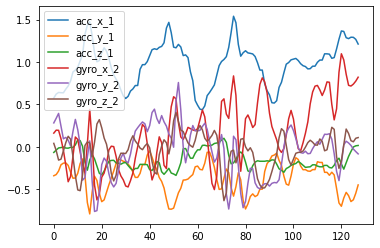

<Figure size 432x288 with 0 Axes>

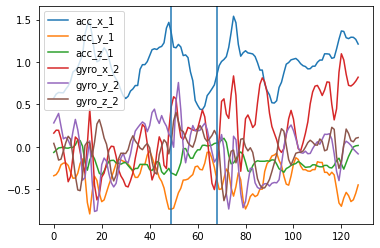

<Figure size 432x288 with 0 Axes>

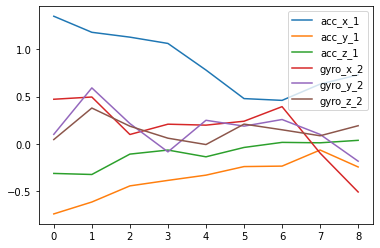

<Figure size 432x288 with 0 Axes>

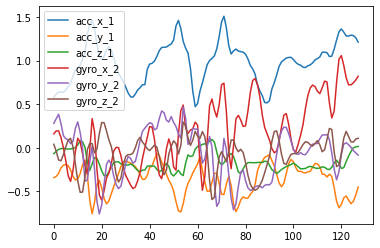

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tslearn.preprocessing import TimeSeriesResampler
import pandas as pd
window = args.windowsize  



index = 1000
start_index  =  dataset.train_slidingwindows[index][1]
end_index    =  dataset.train_slidingwindows[index][2]
original_data = dataset.data_x.iloc[start_index:end_index, 1:-1].reset_index(drop=True)
plt.figure()
original_data.plot()

length_sample  = np.random.randint(int(0.1*window), int(0.2*window))
p = random.uniform(0, 1)
if p >= 0.5:
    ratio = 2
else:
    ratio = 0.5

print(length_sample, "     ", ratio)

sample_start_index = np.random.randint(start_index, start_index+window-length_sample)
sample_end_index   = sample_start_index + length_sample

original_data = dataset.data_x.iloc[start_index:end_index, 1:-1].reset_index(drop=True)
plt.figure()
original_data.plot()
plt.axvline(x=sample_start_index-start_index)
plt.axvline(x=sample_end_index-start_index)


vor_sample    = dataset.data_x.iloc[start_index:sample_start_index, 1:-1]
wraped_sample = dataset.data_x.iloc[sample_start_index:sample_end_index, 1:-1]
nach_sample   = dataset.data_x.iloc[sample_end_index:end_index, 1:-1]

resize_length_sample = int(length_sample*ratio)

resize_data = pd.DataFrame()
for col in wraped_sample.columns:
    ts = wraped_sample[col].values
    new_ts = TimeSeriesResampler(sz=resize_length_sample).fit_transform(ts)
    resize_data[col] = np.squeeze(new_ts)

plt.figure()
resize_data.plot()

all_data = pd.concat([vor_sample,resize_data,nach_sample])
sample_data = pd.DataFrame()
for col in all_data.columns:
    ts = all_data[col].values
    new_ts = TimeSeriesResampler(sz=window).fit_transform(ts)
    sample_data[col] = np.squeeze(new_ts)

plt.figure()
sample_data.plot()

16       1.5
12       0.75


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

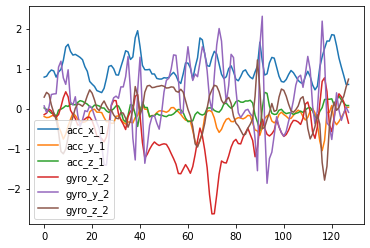

<Figure size 432x288 with 0 Axes>

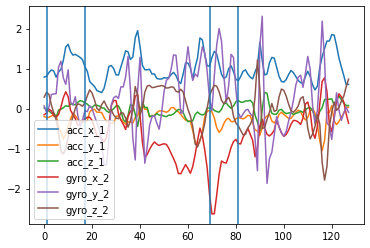

<Figure size 432x288 with 0 Axes>

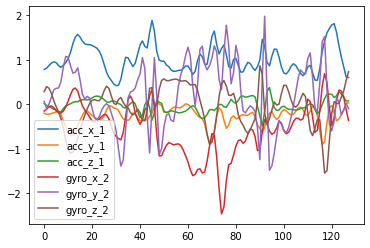

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tslearn.preprocessing import TimeSeriesResampler
import pandas as pd
window = args.windowsize  



index = 200
start_index  =  dataset.train_slidingwindows[index][1]
end_index    =  dataset.train_slidingwindows[index][2]
original_data = dataset.data_x.iloc[start_index:end_index, 1:-1].reset_index(drop=True)
plt.figure()
original_data.plot()


window_data = original_data.copy()
number_of_wrap = np.random.randint(1,4)
index_lists = []
for _ in range(number_of_wrap):

    length_sample  = np.random.randint(int(0.1*window), int(0.15*window))
    p = random.uniform(0, 1)
    if p >= 0.5:
        ratio = 1.5
    else:
        ratio = 0.75

    print(length_sample, "     ", ratio)
    resize_length_sample = int(length_sample*ratio)
    
    sample_start_index = np.random.randint(0, 0+window-length_sample)
    sample_end_index   = sample_start_index + length_sample


    index_lists.append((sample_start_index-0,sample_end_index-0 ))



    vor_sample    = window_data.iloc[0:sample_start_index, :]
    wraped_sample = window_data.iloc[sample_start_index:sample_end_index, :]
    nach_sample   = window_data.iloc[sample_end_index:,:]



    resize_data = pd.DataFrame()
    for col in wraped_sample.columns:
        ts = wraped_sample[col].values
        new_ts = TimeSeriesResampler(sz=resize_length_sample).fit_transform(ts)
        resize_data[col] = np.squeeze(new_ts)
    all_data = pd.concat([vor_sample,resize_data,nach_sample])
    
    
    sample_data = pd.DataFrame()
    for col in all_data.columns:
        ts = all_data[col].values
        new_ts = TimeSeriesResampler(sz=window).fit_transform(ts)
        sample_data[col] = np.squeeze(new_ts)
        
    window_data = sample_data.copy()

    
plt.figure()
original_data.plot()
for sample_start_index,sample_end_index in index_lists:
    plt.axvline(x=sample_start_index)
    plt.axvline(x=sample_end_index)    

plt.figure()
window_data.plot()

## Ramdom Sampling

98


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

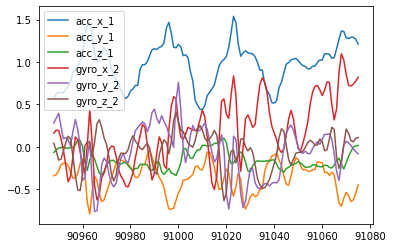

<Figure size 432x288 with 0 Axes>

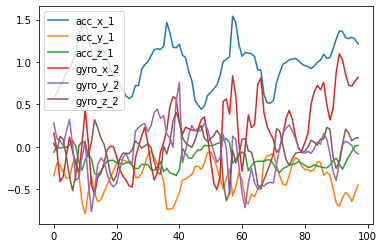

<Figure size 432x288 with 0 Axes>

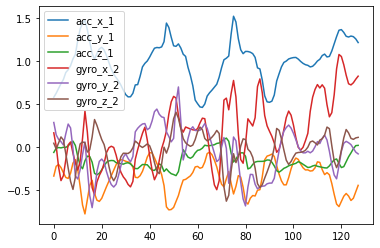

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tslearn.preprocessing import TimeSeriesResampler
import pandas as pd
window = args.windowsize  



index = 1000
start_index  =  dataset.train_slidingwindows[index][1]
end_index    =  dataset.train_slidingwindows[index][2]
original_data = dataset.data_x.iloc[start_index:end_index, 1:-1]
plt.figure()
original_data.plot()

length_sample  = np.random.randint(int(0.6*window), int(0.8*window))
print(length_sample)
index_list = list(np.arange(window))
sampled_index = random.sample(index_list, length_sample)
sampled_index = sorted(sampled_index)
original_values = original_data.values
sampled_Values = original_values[sampled_index]
sample_data = pd.DataFrame(sampled_Values)
sample_data.columns = original_data.columns
plt.figure()
sample_data.plot()


resize_data = pd.DataFrame()
for col in sample_data.columns:
    ts = sample_data[col].values
    new_ts = TimeSeriesResampler(sz=window).fit_transform(ts)
    resize_data[col] = np.squeeze(new_ts)
plt.figure()
resize_data.plot()



## Time Wrap

In [ ]:
np.clip(scale*time_warp, 0, x.shape[0]-1)

In [ ]:
warp_steps[:,1] * random_warps[:,1]

array([  0.        ,  12.65499073,  66.78220807,  42.25802657,
        91.98760328, 103.59082009])

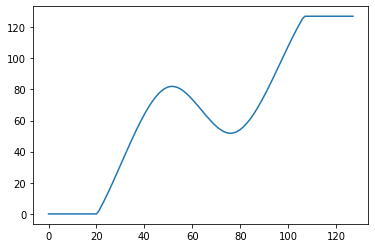

In [ ]:
from scipy.interpolate import CubicSpline
orig_steps = np.arange(128)
sigma = 0.2
knot = 4
random_warps = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, 6))

warp_steps = (np.ones((6,1))*(np.linspace(0, 128-1., num=knot+2))).T

time_warp = CubicSpline(warp_steps[:,1], warp_steps[:,1] * random_warps[:,1])(orig_steps)

scale = (128-1)/time_warp[-1]

plt.plot(np.clip(scale*time_warp, 0, 128-1))

In [ ]:
time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[:,dim])(orig_steps)

In [ ]:
def time_warp(x, sigma=0.07, knot=5):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[0])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(knot+2))
    #plt.plot(random_warps)
    warp_steps = (np.ones((x.shape[1],1))*(np.linspace(0, x.shape[0]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)

    for dim in range(x.shape[1]):
        time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps)(orig_steps)
        #plt.figure()
        #plt.plot(time_warp)
        scale = (x.shape[0]-1)/time_warp[-1]
        ret[:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[0]-1), x[:,dim]).T
    return ret

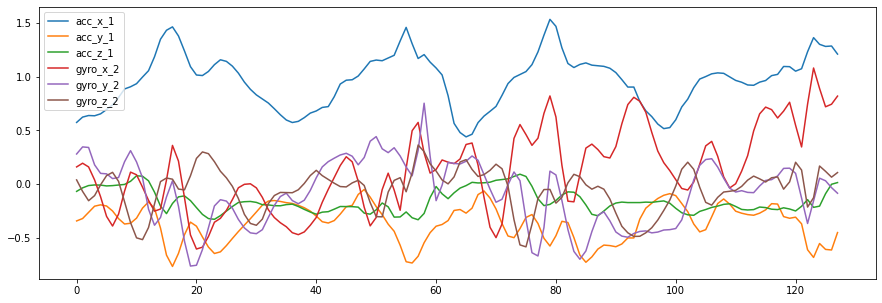

In [ ]:
def time_warp(x, sigma=0.07, knot=5):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[0])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(knot+2))
    #plt.plot(random_warps)
    warp_steps = (np.ones((x.shape[1],1))*(np.linspace(0, x.shape[0]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)

    for dim in range(x.shape[1]):
        time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps)(orig_steps)
        #plt.figure()
        #plt.plot(time_warp)
        scale = (x.shape[0]-1)/time_warp[-1]
        ret[:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[0]-1), x[:,dim]).T
    return ret
time_wrap_data = pd.DataFrame(time_warp(original_data.values), columns  = original_data.columns)
time_wrap_data.plot(figsize=(15,5))
plt.show()

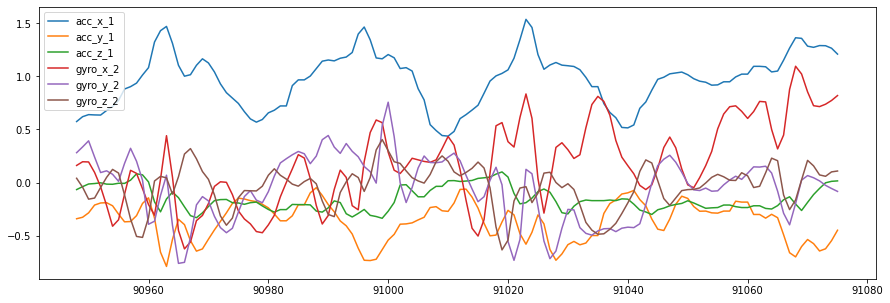

In [ ]:
original_data.plot(figsize=(15,5))
plt.show()

## Crop (window Slicing)|

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

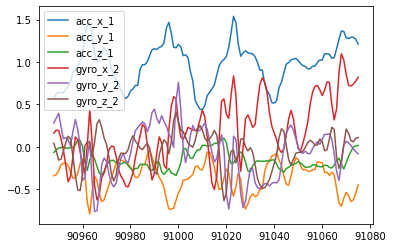

<Figure size 432x288 with 0 Axes>

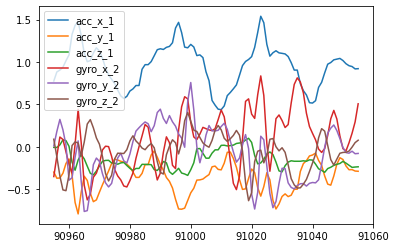

<Figure size 432x288 with 0 Axes>

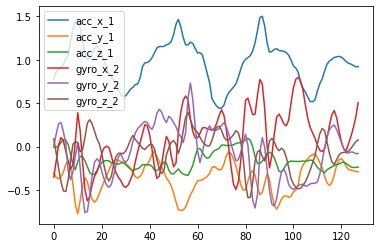

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tslearn.preprocessing import TimeSeriesResampler
import pandas as pd
window = args.windowsize  



index = 1000
start_index  =  dataset.train_slidingwindows[index][1]
end_index    =  dataset.train_slidingwindows[index][2]
original_data = dataset.data_x.iloc[start_index:end_index, 1:-1]
plt.figure()
original_data.plot()

length_sample  = np.random.randint(int(0.6*window), int(0.9*window))
sample_start_index = np.random.randint(start_index, start_index+window-length_sample)
sample_end_index  = sample_start_index+length_sample
sample_data = dataset.data_x.iloc[sample_start_index:sample_end_index, 1:-1]
plt.figure()
sample_data.plot()


resize_data = pd.DataFrame()
for col in sample_data.columns:
    ts = sample_data[col].values
    new_ts = TimeSeriesResampler(sz=window).fit_transform(ts)
    resize_data[col] = np.squeeze(new_ts)
plt.figure()
resize_data.plot()

## Scale

165


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

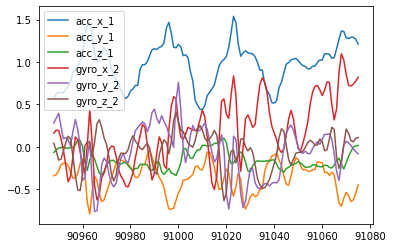

<Figure size 432x288 with 0 Axes>

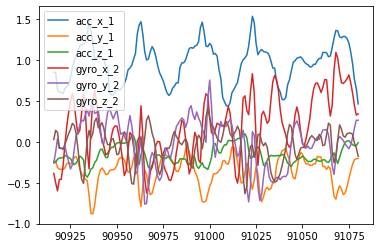

<Figure size 432x288 with 0 Axes>

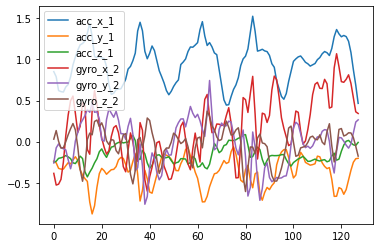

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tslearn.preprocessing import TimeSeriesResampler
import pandas as pd
window = args.windowsize  
augmentation_window = int(0.25*window)


index = 1000
start_index  =  dataset.train_slidingwindows[index][1]
end_index    =  dataset.train_slidingwindows[index][2]
original_data = dataset.data_x.iloc[start_index:end_index, 1:-1]
plt.figure()
original_data.plot()


sample_start_index = max(0,np.random.randint(start_index-augmentation_window, start_index))
sample_end_index =  min(dataset.data_x.shape[0],np.random.randint(end_index, end_index+augmentation_window))
sample_data = dataset.data_x.iloc[sample_start_index:sample_end_index, 1:-1]
print(sample_end_index-sample_start_index)
plt.figure()
sample_data.plot()


resize_data = pd.DataFrame()
for col in sample_data.columns:
    ts = sample_data[col].values
    new_ts = TimeSeriesResampler(sz=window).fit_transform(ts)
    resize_data[col] = np.squeeze(new_ts)
plt.figure()
resize_data.plot()

In [ ]:
index = 1000
start_index  =  dataset.train_slidingwindows[index][1]
end_index    =  dataset.train_slidingwindows[index][2]
data = dataset.data_x.iloc[start_index:end_index, 1:-1]
plt.figure()
data.plot()

NameError: name 'plt' is not defined

In [ ]:
from tslearn.preprocessing import TimeSeriesResampler
ts = np.arange(5)
new_ts = TimeSeriesResampler(sz=9).fit_transform(ts)
final_ts = np.squeeze(new_ts)
print(ts)   # [0 1 2 3 4]
print(new_ts)  # [[[0. ] [0.5] [1. ] [1.5] [2. ] [2.5] [3. ] [3.5] [4. ]]]
print(final_ts)  # [0. 0.5 1. 1.5 2. 2.5 3. 3.5 4.]

[0 1 2 3 4]
[[[0. ]
  [0.5]
  [1. ]
  [1.5]
  [2. ]
  [2.5]
  [3. ]
  [3.5]
  [4. ]]]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]


In [ ]:
from time import time

ts = np.arange(5000)
start = time()

new_ts = TimeSeriesResampler(sz=10000).fit_transform(ts)
final_ts = np.squeeze(new_ts)
end = time()
print(end-start)
print(ts)   # [0 1 2 3 4]
print(new_ts)  # [[[0. ] [0.5] [1. ] [1.5] [2. ] [2.5] [3. ] [3.5] [4. ]]]
print(final_ts)  # [0. 0.5 1. 1.5 2. 2.5 3. 3.5 4.]

0.0009915828704833984
[   0    1    2 ... 4997 4998 4999]
[[[0.00000000e+00]
  [4.99949995e-01]
  [9.99899990e-01]
  ...
  [4.99800010e+03]
  [4.99850005e+03]
  [4.99900000e+03]]]
[0.00000000e+00 4.99949995e-01 9.99899990e-01 ... 4.99800010e+03
 4.99850005e+03 4.99900000e+03]


In [ ]:
data = dataset.data_x.set_index('sub_id').copy()
        columns = data.columns[:-1]
        groups = {}
        for col in columns:
            index = col.split("_")[-1]
            if index in groups.keys():
                groups[index].append(col)
            else:
                groups[index] = [col]

        index = 1
        columns_mapping = {}
        for key in groups.keys():
            cols = groups[key]
            cols_set = []
            for col in cols:
                cols_set.append(col.split("_")[0])
            cols_set = set(cols_set)
            for col_begin in cols_set:
                for col in cols:
                    if col.split("_")[0]==col_begin:
                        columns_mapping[col] = col[:-2]+"_"+str(index)
                index= index+1

        columns = [columns_mapping[col] for col in data.columns[:-1]] + ["sub"]
        data.columns = columns

In [ ]:
columns

NameError: name 'columns' is not defined

In [ ]:
#data = dataset.data_x.set_index('sub_id').copy()
data

,acc_x_2,acc_y_2,acc_z_2,diff_acc_x_3,diff_acc_y_3,diff_acc_z_3,diff_gyro_x_4,diff_gyro_y_4,diff_gyro_z_4,grav_acc_x_1,grav_acc_y_1,grav_acc_z_1,gyro_x_5,gyro_y_5,gyro_z_5,sub
sub_id,,,,,,,,,,,,,,,,
1_1,0.390029,-0.219739,-0.161668,-0.006944,0.019444,0.027778,0.042455,0.088881,-0.007636,0.432648,0.176403,0.720683,-0.013726,-0.238178,-0.340682,1
1_1,0.549041,-0.323713,-0.223046,-0.006944,0.019444,0.027778,0.042455,0.088881,-0.007636,0.443978,0.169720,0.714915,-0.037929,-0.178095,-0.397669,1
1_1,0.368536,-0.203470,-0.159361,-0.029167,0.006944,-0.023611,-0.010996,0.257174,0.044899,0.455268,0.163014,0.709100,0.014601,0.102821,-0.319634,1
1_1,0.445051,-0.269136,-0.211633,0.000000,0.000000,0.000000,-0.069944,0.091324,-0.005192,0.466513,0.156288,0.703239,-0.076276,0.184696,-0.336631,1
1_1,0.398665,-0.241334,-0.183720,-0.002778,-0.013889,-0.008333,-0.030849,0.109039,-0.024129,0.477710,0.149544,0.697330,-0.090396,0.312366,-0.361742,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30_61,0.040389,0.208158,0.017585,-0.001389,0.018056,0.151389,-0.553138,-0.541227,0.064141,0.378595,0.289740,0.897164,-1.157026,-0.969183,-0.055706,30
30_61,0.074591,0.228987,0.019099,0.000000,0.000000,0.000000,0.296270,0.224493,0.001527,0.373686,0.286057,0.903124,-0.982608,-0.926986,-0.068404,30
30_61,0.083070,0.187067,0.009945,0.043056,-0.008333,-0.016667,0.589790,0.235794,0.009774,0.368826,0.282359,0.909041,-0.284301,-0.486244,-0.028968,30


<AxesSubplot:xlabel='sub_id'>

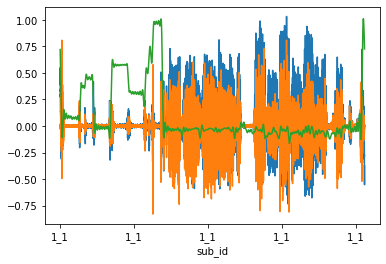

In [ ]:
data = dataset.data_x.set_index('sub_id').copy()
data.loc["1_1","acc_x_1"].plot()
data.loc["1_1","diff_acc_x_1"].plot()
data.loc["1_1","grav_acc_z_1"].plot()

In [ ]:
data.columns

Index(['acc_x_1', 'acc_y_1', 'acc_z_1', 'diff_acc_x_1', 'diff_acc_y_1',
       'diff_acc_z_1', 'diff_gyro_x_2', 'diff_gyro_y_2', 'diff_gyro_z_2',
       'grav_acc_x_1', 'grav_acc_y_1', 'grav_acc_z_1', 'gyro_x_2', 'gyro_y_2',
       'gyro_z_2', 'sub'],
      dtype='object')

In [ ]:
dataset.data_x

,sub_id,acc_x_1,acc_y_1,acc_z_1,gyro_x_2,gyro_y_2,gyro_z_2,sub
0,1_1,0.918056,-0.112500,0.509722,-0.054978,-0.069639,-0.030849,1
1,1_1,0.911111,-0.093056,0.537500,-0.012523,0.019242,-0.038485,1
2,1_1,0.881944,-0.086111,0.513889,-0.023518,0.276417,0.006414,1
3,1_1,0.881944,-0.086111,0.513889,-0.093462,0.367741,0.001222,1
4,1_1,0.879167,-0.100000,0.505556,-0.124311,0.476780,-0.022907,1
...,...,...,...,...,...,...,...,...
1122767,30_61,0.430556,0.501389,0.923611,-1.154535,-0.653931,0.004276,30
1122768,30_61,0.430556,0.501389,0.923611,-0.858266,-0.429438,0.005803,30
1122769,30_61,0.473611,0.493056,0.906944,-0.268475,-0.193644,0.015577,30
1122770,30_61,0.472222,0.502778,0.884722,0.274278,-0.108734,0.105069,30


In [ ]:
data

NameError: name 'data' is not defined

In [ ]:
col_names = list(dataset.data_x.columns)[1:-1]

In [ ]:
import pandas as pd

In [ ]:
dataset.data_x#["sub_id"].unique()

data = dataset.data_x.set_index('sub_id').copy()
sensor_cols = data.columns[:-1]


filtered_data = []
for sub_id in data.index.unique():
    temp = data.loc[sub_id,sensor_cols]
    filtered_temp = pd.DataFrame()

    for col in temp.columns:
        t_signal=np.array(temp[col]) # copie the signal values in 1D numpy array

        if 'acc' in col: 
            # the 2nd output DC_component is the gravity_acc
            # The 3rd one is the body_component which in this case the body_acc
            _,grav_acc,body_acc,_=components_selection_one_signal(t_signal,freq1,freq2) # apply components selection

            filtered_temp[col]=body_acc
            filtered_temp['grav_'+col]= grav_acc
        
        elif 'gyro' in col: 
            
            # The 3rd output of components_selection is the body_component which in this case the body_gyro component
            _,_,body_gyro,_=components_selection_one_signal(t_signal,freq1,freq2)  # apply components selection
            filtered_temp[col]=body_gyro # t_body_acc storing with the appropriate axis selected 
    filtered_temp = filtered_temp[sorted(list(filtered_temp.columns))]
    filtered_temp.index = temp.index
    filtered_data.append(filtered_temp)
    
filtered_data = pd.concat(filtered_data)
filtered_data = pd.concat([filtered_data, data.iloc[:,-1]], axis=1)

In [ ]:
filtered_data

,acc_x_1,acc_y_1,acc_z_1,grav_acc_x_1,grav_acc_y_1,grav_acc_z_1,gyro_x_2,gyro_y_2,gyro_z_2,sub
sub_id,,,,,,,,,,
1_1,0.390029,-0.219739,-0.161668,0.432648,0.176403,0.720683,-0.013726,-0.238178,-0.340682,1
1_1,0.549041,-0.323713,-0.223046,0.443978,0.169720,0.714915,-0.037929,-0.178095,-0.397669,1
1_1,0.368536,-0.203470,-0.159361,0.455268,0.163014,0.709100,0.014601,0.102821,-0.319634,1
1_1,0.445051,-0.269136,-0.211633,0.466513,0.156288,0.703239,-0.076276,0.184696,-0.336631,1
1_1,0.398665,-0.241334,-0.183720,0.477710,0.149544,0.697330,-0.090396,0.312366,-0.361742,1
...,...,...,...,...,...,...,...,...,...,...
30_61,0.040389,0.208158,0.017585,0.378595,0.289740,0.897164,-1.157026,-0.969183,-0.055706,30
30_61,0.074591,0.228987,0.019099,0.373686,0.286057,0.903124,-0.982608,-0.926986,-0.068404,30
30_61,0.083070,0.187067,0.009945,0.368826,0.282359,0.909041,-0.284301,-0.486244,-0.028968,30


<AxesSubplot:xlabel='sub_id'>

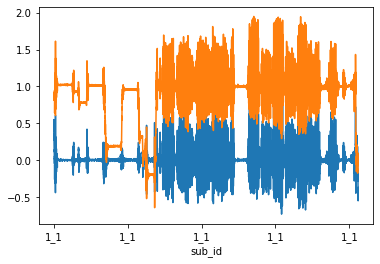

In [ ]:
filtered_data.loc["1_1","acc_x_1"].plot()
data.loc["1_1","acc_x_1"].plot()

<AxesSubplot:xlabel='sub_id'>

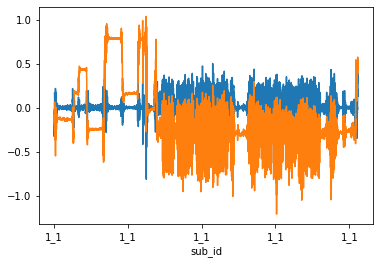

In [ ]:
filtered_data.loc["1_1","acc_y_1"].plot()
data.loc["1_1","acc_y_1"].plot()

<AxesSubplot:xlabel='sub_id'>

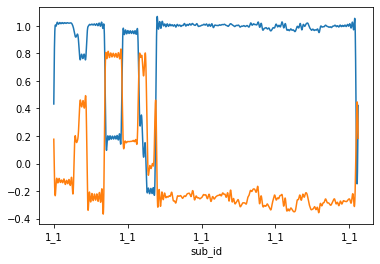

In [ ]:
filtered_data.loc["1_1","grav_acc_x_1"].plot()
filtered_data.loc["1_1","grav_acc_y_1"].plot()
#data.loc["1_1","grav_acc_x_1"].plot()

In [ ]:
filtered_data

,acc_x_1,acc_y_1,acc_z_1,grav_acc_x_1,grav_acc_y_1,grav_acc_z_1,gyro_x_2,gyro_y_2,gyro_z_2,sub
sub_id,,,,,,,,,,
1_1,0.390029,-0.219739,-0.161668,0.432648,0.176403,0.720683,-0.013726,-0.238178,-0.340682,1
1_1,0.549041,-0.323713,-0.223046,0.443978,0.169720,0.714915,-0.037929,-0.178095,-0.397669,1
1_1,0.368536,-0.203470,-0.159361,0.455268,0.163014,0.709100,0.014601,0.102821,-0.319634,1
1_1,0.445051,-0.269136,-0.211633,0.466513,0.156288,0.703239,-0.076276,0.184696,-0.336631,1
1_1,0.398665,-0.241334,-0.183720,0.477710,0.149544,0.697330,-0.090396,0.312366,-0.361742,1
...,...,...,...,...,...,...,...,...,...,...
30_61,0.040389,0.208158,0.017585,0.378595,0.289740,0.897164,-1.157026,-0.969183,-0.055706,30
30_61,0.074591,0.228987,0.019099,0.373686,0.286057,0.903124,-0.982608,-0.926986,-0.068404,30
30_61,0.083070,0.187067,0.009945,0.368826,0.282359,0.909041,-0.284301,-0.486244,-0.028968,30


In [ ]:

columns = ["diff_"+i for i in col_names]

# Train_vali_diff
diff_data = []
for id in temp.index.unique():
    diff_data.append(filtered_data.loc[id,sensor_cols].diff())
diff_data = pd.concat(diff_data)

diff_data.columns = columns
diff_data.fillna(method ="backfill",inplace=True)
temp = pd.concat([filtered_data.iloc[:,:-1],  diff_data, filtered_data.iloc[:,-1]], axis=1)

In [ ]:
temp

,acc_x_1,acc_y_1,acc_z_1,grav_acc_x_1,grav_acc_y_1,grav_acc_z_1,gyro_x_2,gyro_y_2,gyro_z_2,diff_acc_x_1,diff_acc_y_1,diff_acc_z_1,diff_gyro_x_2,diff_gyro_y_2,diff_gyro_z_2,sub
sub_id,,,,,,,,,,,,,,,,
1_1,0.390029,-0.219739,-0.161668,0.432648,0.176403,0.720683,-0.013726,-0.238178,-0.340682,0.159013,-0.103974,-0.061377,-0.024203,0.060083,-0.056987,1
1_1,0.549041,-0.323713,-0.223046,0.443978,0.169720,0.714915,-0.037929,-0.178095,-0.397669,0.159013,-0.103974,-0.061377,-0.024203,0.060083,-0.056987,1
1_1,0.368536,-0.203470,-0.159361,0.455268,0.163014,0.709100,0.014601,0.102821,-0.319634,-0.180505,0.120243,0.063685,0.052529,0.280916,0.078035,1
1_1,0.445051,-0.269136,-0.211633,0.466513,0.156288,0.703239,-0.076276,0.184696,-0.336631,0.076515,-0.065667,-0.052272,-0.090877,0.081875,-0.016997,1
1_1,0.398665,-0.241334,-0.183720,0.477710,0.149544,0.697330,-0.090396,0.312366,-0.361742,-0.046386,0.027802,0.027914,-0.014119,0.127670,-0.025111,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30_61,0.040389,0.208158,0.017585,0.378595,0.289740,0.897164,-1.157026,-0.969183,-0.055706,-0.013753,0.023212,0.120522,-0.437503,-0.410067,0.085011,30
30_61,0.074591,0.228987,0.019099,0.373686,0.286057,0.903124,-0.982608,-0.926986,-0.068404,0.034202,0.020829,0.001514,0.174418,0.042197,-0.012699,30
30_61,0.083070,0.187067,0.009945,0.368826,0.282359,0.909041,-0.284301,-0.486244,-0.028968,0.008479,-0.041919,-0.009154,0.698307,0.440741,0.039436,30


In [ ]:
# necessary functions
from scipy.fftpack import fft,fftfreq,ifft
# Importing Scipy 
import scipy as sp
freq1 = 0.3 
freq2 = 20  
sampling_freq = 50


def components_selection_one_signal(t_signal,freq1,freq2):
    """
    DC_component: f_signal values having freq between [-0.3 hz to 0 hz] and from [0 hz to 0.3hz] 
                                                                (-0.3 and 0.3 are included)
    
    noise components: f_signal values having freq between [-25 hz to 20 hz[ and from ] 20 hz to 25 hz] 
                                                                  (-25 and 25 hz inculded 20hz and -20hz not included)
    
    selecting body_component: f_signal values having freq between [-20 hz to -0.3 hz] and from [0.3 hz to 20 hz] 
                                                                  (-0.3 and 0.3 not included , -20hz and 20 hz included)
    """

    t_signal=np.array(t_signal)
    t_signal_length=len(t_signal) # number of points in a t_signal
    
    # the t_signal in frequency domain after applying fft
    f_signal=fft(t_signal) # 1D numpy array contains complex values (in C)
    
    # generate frequencies associated to f_signal complex values
    freqs=np.array(sp.fftpack.fftfreq(t_signal_length, d=1/float(sampling_freq))) # frequency values between [-25hz:+25hz]
    

    
    
    f_DC_signal=[] # DC_component in freq domain
    f_body_signal=[] # body component in freq domain numpy.append(a, a[0])
    f_noise_signal=[] # noise in freq domain
    
    for i in range(len(freqs)):# iterate over all available frequencies
        
        # selecting the frequency value
        freq=freqs[i]
        
        # selecting the f_signal value associated to freq
        value= f_signal[i]
        
        # Selecting DC_component values 
        if abs(freq)>0.3:# testing if freq is outside DC_component frequency ranges
            f_DC_signal.append(float(0)) # add 0 to  the  list if it was the case (the value should not be added)                                       
        else: # if freq is inside DC_component frequency ranges 
            f_DC_signal.append(value) # add f_signal value to f_DC_signal list
    
        # Selecting noise component values 
        if (abs(freq)<=20):# testing if freq is outside noise frequency ranges 
            f_noise_signal.append(float(0)) # # add 0 to  f_noise_signal list if it was the case 
        else:# if freq is inside noise frequency ranges 
            f_noise_signal.append(value) # add f_signal value to f_noise_signal

        # Selecting body_component values 
        if (abs(freq)<=0.3 or abs(freq)>20):# testing if freq is outside Body_component frequency ranges
            f_body_signal.append(float(0))# add 0 to  f_body_signal list
        else:# if freq is inside Body_component frequency ranges
            f_body_signal.append(value) # add f_signal value to f_body_signal list
    
    ################### Inverse the transformation of signals in freq domain ########################
    # applying the inverse fft(ifft) to signals in freq domain and put them in float format
    t_DC_component= ifft(np.array(f_DC_signal)).real
    t_body_component= ifft(np.array(f_body_signal)).real
    t_noise=ifft(np.array(f_noise_signal)).real
    
    total_component=t_signal-t_noise # extracting the total component(filtered from noise) 
                                     #  by substracting noise from t_signal (the original signal).
    

    return (total_component,t_DC_component,t_body_component,t_noise) 


In [ ]:
from torch.utils.data import DataLoader
print("================ {} Mode ====================".format(dataset.exp_mode))
print("================ {} CV ======================".format(dataset.num_of_cv))
for i in range(dataset.num_of_cv):
    dataset.update_train_val_test_keys()
    train_data  = data_set(args,dataset,"train")
    test_data  = data_set(args,dataset,"test")
    vali_data  = data_set(args,dataset,"vali")
    
    
        # form the dataloader
    train_data_loader = DataLoader(train_data,  
                                    batch_size   =  args.batch_size,
                                    shuffle      =  args.shuffle,
                                    num_workers  =  0,
                                    drop_last    =  args.drop_last)

    vali_data_loader = DataLoader(vali_data,  
                                    batch_size   =  args.batch_size,
                                    shuffle      =  args.shuffle,
                                    num_workers  =  0,
                                    drop_last    =  args.drop_last)

    test_data_loader = DataLoader(test_data,  
                                    batch_size   =  args.batch_size,
                                    shuffle      =  args.shuffle,
                                    num_workers  =  0,
                                    drop_last    =  args.drop_last)

================ LOCV Mode ====================
================ 10 CV ======================
Leave one Out Experiment : The 1 Part as the test
[-] Target sampling weights:  [0.00069396 0.00071531 0.00078309 0.00066138 0.00059916 0.00059067
 0.00793651 0.01075269 0.00689655 0.00763359 0.00598802 0.008     ]
Train data number :  9777
The number of classes is :  12
The input_length  is :  128
The channel_in is :  3
Test data number :  6629
Validation data number :  1726
Leave one Out Experiment : The 2 Part as the test
[-] Target sampling weights:  [0.00069156 0.00071582 0.00077459 0.00064516 0.0005963  0.0005963
 0.00819672 0.01020408 0.00662252 0.00740741 0.00617284 0.00806452]
Train data number :  9830
The number of classes is :  12
The input_length  is :  128
The channel_in is :  3
Test data number :  6307
Validation data number :  1735
Leave one Out Experiment : The 3 Part as the test
[-] Target sampling weights:  [0.00068027 0.00071225 0.00077821 0.00064103 0.00059067 0.00059701
 0